In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold

import tensorflow as tf
from keras.utils import to_categorical

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow warnings (1=INFO, 2=WARNING, 3=ERROR)

2025-04-17 00:09:47.814949: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


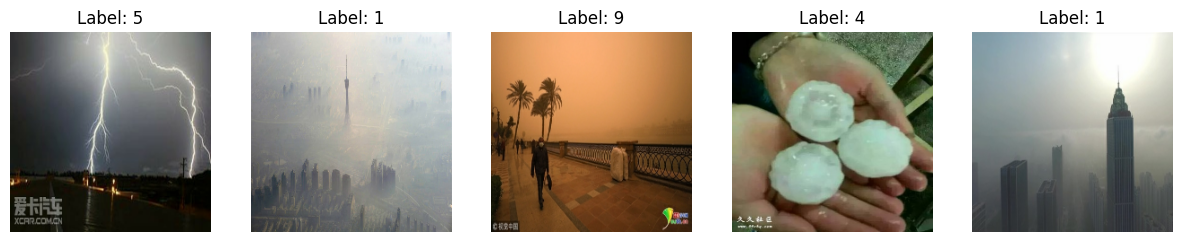

In [5]:
# Dataset/hyperparams
sandbox_dir = "../Data/Weather_Dataset"
batch_size = 32
image_size = (224, 224) #do not change for resnet50

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="both",
    seed=1234,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

### USE THESE 
train_dataset, val_dataset = dataset 
 
class_names = train_dataset.class_names

# print first 5 of training set
for images, labels in train_dataset.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].numpy()}")
    plt.show()
    break

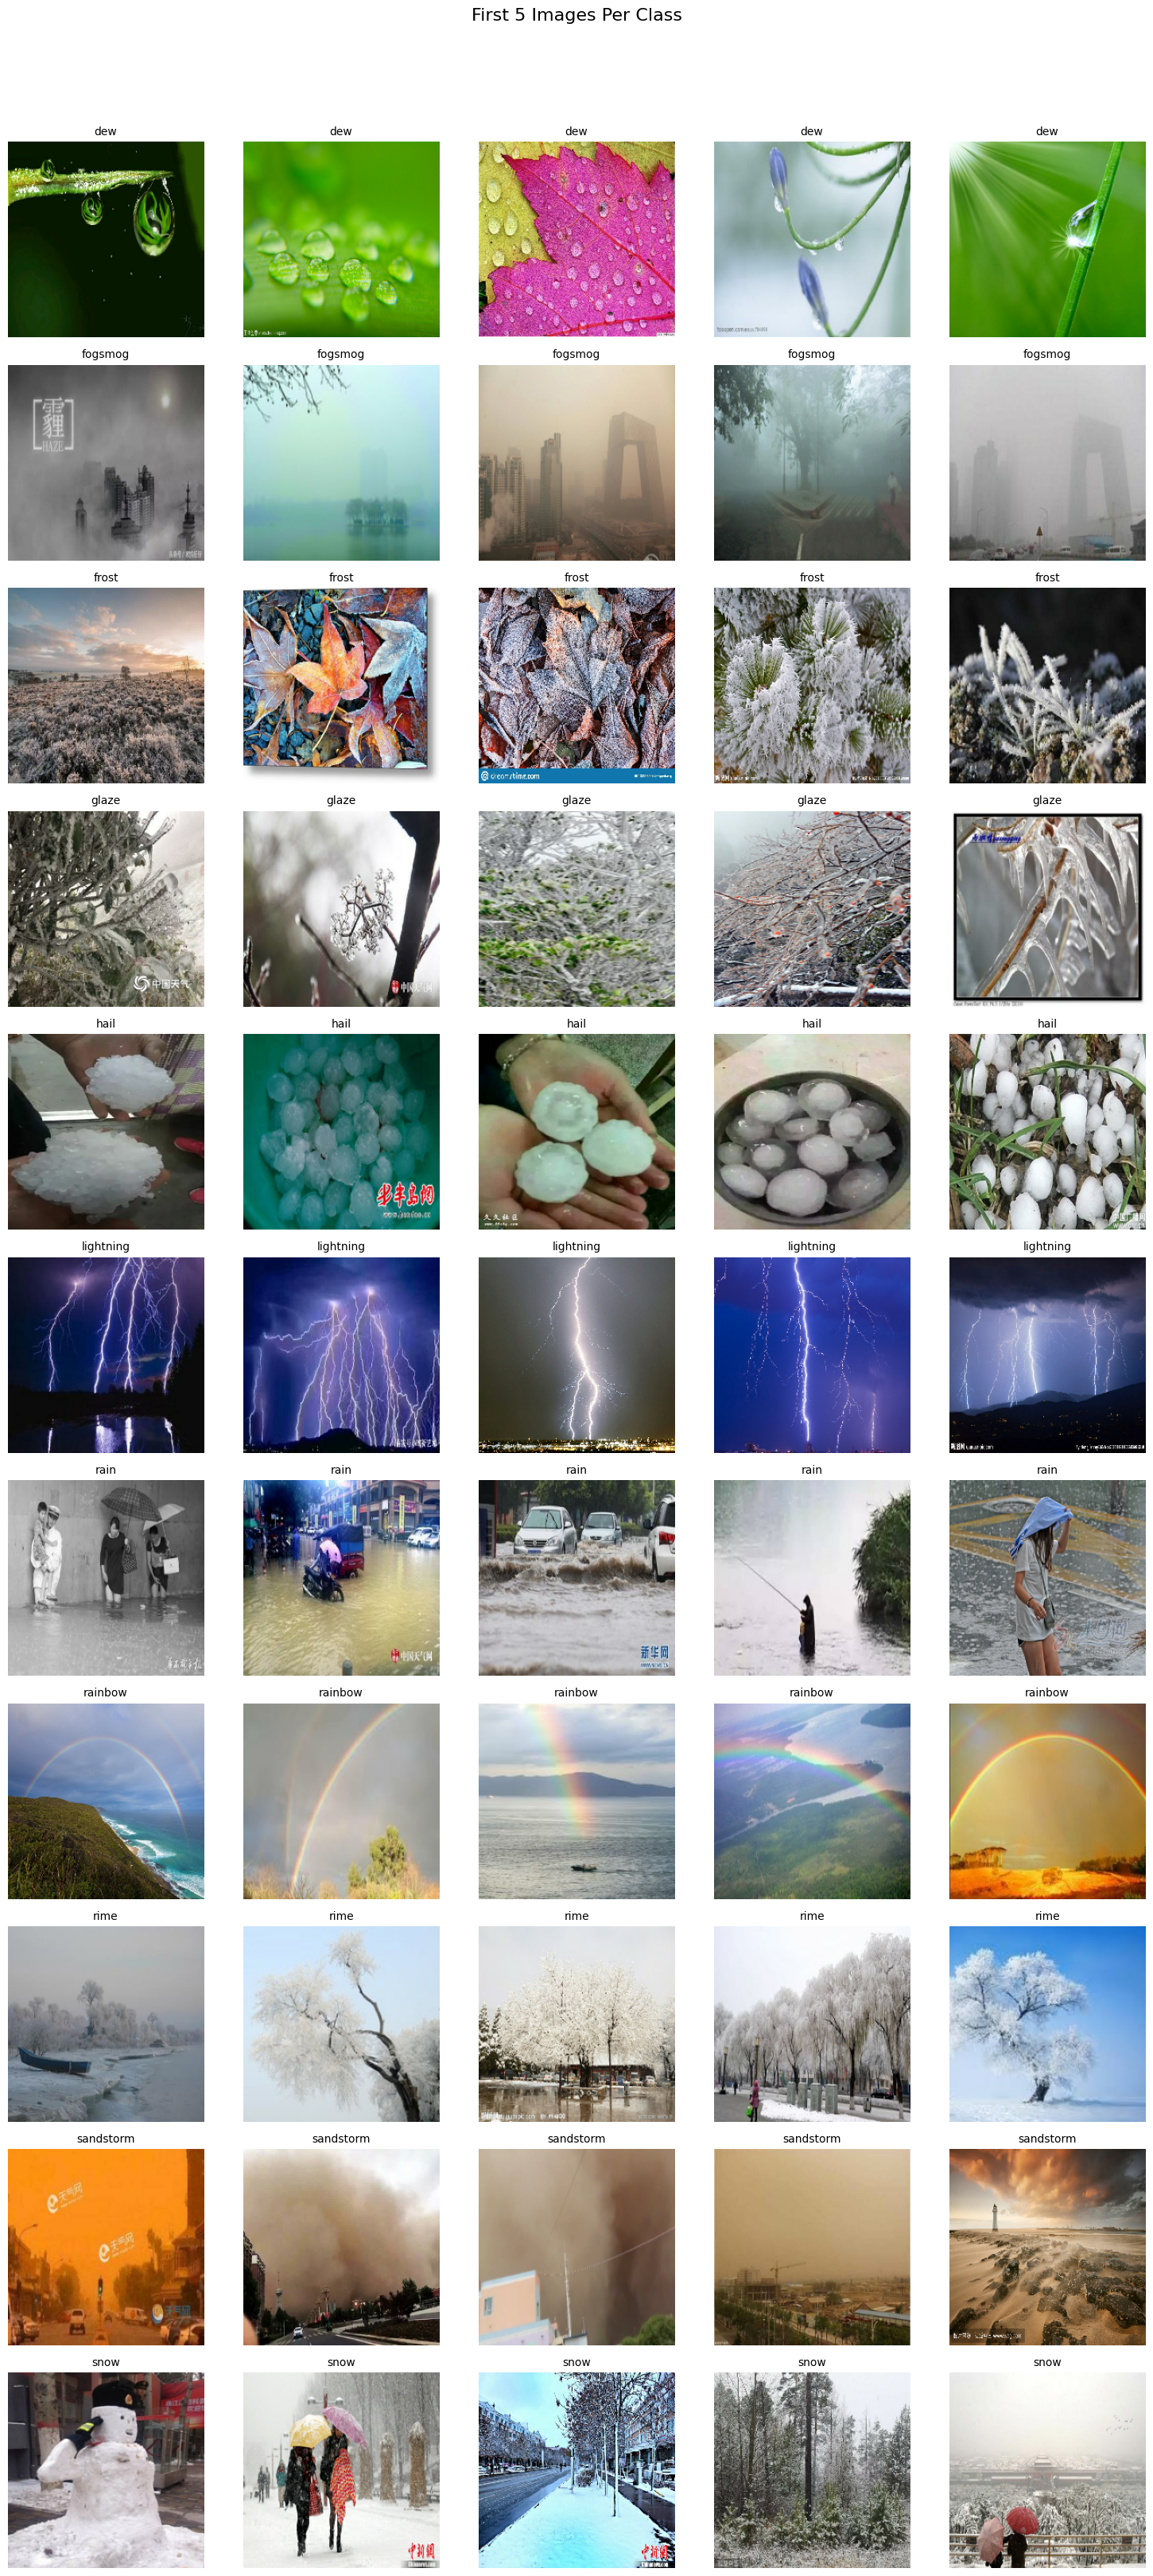

In [3]:
def display_first_images_per_class_in_one_plot(dataset, num_classes, class_names=None):
    # Unbatch the dataset to access individual samples
    unbatched_dataset = dataset.unbatch()

    # Create a dictionary to store the first 5 images per class
    images_per_class = {i: [] for i in range(num_classes)}

    # Iterate through the dataset and collect images for each class
    for image, label in unbatched_dataset:
        label = label.numpy()
        if len(images_per_class[label]) < 5:  # Collect up to 5 images per class
            images_per_class[label].append(image.numpy())
        if all(len(images) == 5 for images in images_per_class.values()):  # Stop if all classes have 5 images
            break

    # Create a single plot with rows for each class and 5 images per row
    fig, axes = plt.subplots(num_classes, 5, figsize=(15, num_classes * 3))
    fig.suptitle("First 5 Images Per Class", fontsize=16)

    for class_label, images in images_per_class.items():
        for i in range(5):
            ax = axes[class_label, i]
            ax.imshow(images[i].astype("uint8"))
            ax.axis("off")
            # Add a title to each image
            label_text = class_names[class_label] if class_names else f"Class {class_label}"
            ax.set_title(label_text, fontsize=10)

        # Add class label to the first column of each row
        row_label_text = class_names[class_label] if class_names else f"Class {class_label}"
        axes[class_label, 0].set_ylabel(row_label_text, fontsize=12, rotation=0, labelpad=50, ha='right', va='center')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Assuming train_dataset, num_classes, and class_names are already defined
# If class_names is not available, pass None
display_first_images_per_class_in_one_plot(train_dataset, 11, class_names=train_dataset.class_names)

In [4]:
# Convert the train dataset into two lists for images and labels
X_train, X_val, Y_train, Y_val = [], [], [], []

# Iterate through the batches
for images, labels in train_dataset:
    X_train.append(images)
    Y_train.append(labels)

# Iterate through the batches
for images, labels in val_dataset:
    X_val.append(images)
    Y_val.append(labels)

# Convert lists to TensorFlow tensors
X_train = tf.concat(X_train, axis=0).numpy()  # Combine batches into one tensor
Y_train = tf.concat(Y_train, axis=0).numpy()  # Combine labels into one tensor
X_val = tf.concat(X_val, axis=0).numpy()  # Combine batches into one tensor
Y_val = tf.concat(Y_val, axis=0).numpy()  # Combine labels into one tensor

# Split training data into training and validation sets so that we can evaluate on validation set and leave the test set unseen for final model evaluation
X_val, X_test, Y_val, Y_test = train_test_split(
    X_val, Y_val, test_size=0.5, random_state=42  # 50% of the 20% test data for validation
)                                                     # results in 80% training, 10% validation, 10% test
                                                      # expected to improve performance due to smaller dataset of images

# Convert back to TensorFlow tensors if needed
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
Y_train = tf.convert_to_tensor(Y_train)
Y_val = tf.convert_to_tensor(Y_val)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

2025-04-16 19:49:25.314488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-16 19:49:26.219345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train shape: (5490, 224, 224, 3)
Y_train shape: (5490,)
X_val shape: (686, 224, 224, 3)
Y_val shape: (686,)


Class Names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


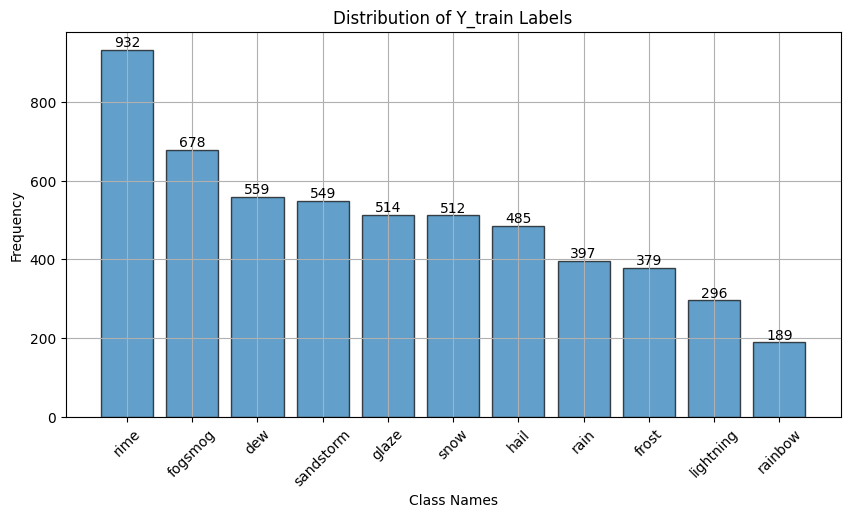

In [5]:
# Get class names from the dataset
class_names = train_dataset.class_names
print("Class Names:", class_names)

# Convert Tensor to NumPy array
Y_train_np = Y_train.numpy()

# Create a dictionary to map label indices to folder names
label_to_class = {i: class_names[i] for i in range(len(class_names))}

# Map labels to class names
Y_train_classes = [label_to_class[label] for label in Y_train_np]

# Count the frequency of each class
class_counts = {class_name: Y_train_classes.count(class_name) for class_name in class_names}

# Sort the class counts by frequency
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the distribution with class names
plt.figure(figsize=(10, 5))
bars = plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), edgecolor='black', alpha=0.7)
plt.title("Distribution of Y_train Labels")
plt.xlabel("Class Names")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(rotation=45)

# Label the frequencies on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.show()

In [6]:
# Normalize the pixel values to [0, 1]
X_train = tf.cast(X_train, tf.float32) / 255.0
X_val = tf.cast(X_val, tf.float32) / 255.0

# Flatten the images using TensorFlow
X_train = tf.reshape(X_train, (tf.shape(X_train)[0], -1))
X_val = tf.reshape(X_val, (tf.shape(X_val)[0], -1))

# Print the shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (5490, 150528)
X_val shape: (686, 150528)


In [2]:
def build_model(num_features, learning_rate):
  """Build a TF logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=11,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='softmax',     # softmax activation function for mutliclass classification
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['f1_score', 'auc', 'categorical_accuracy', 'precision', 'recall'])  # Categorical cross entropy (multiclass log loss)
  
  print(model.summary())

  return model

In [3]:
# Plot History and Evaluate Model
def plot_history(model_history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_categorical_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Training Loss')
    plt.show()
    
def evaluate_model(model, X_val, y_val):
    # Evaluate the model on the validation set
    val_metrics = model.evaluate(X_val, y_val, verbose=0)

    # Extract metrics in the correct order
    val_loss = val_metrics[0]
    val_f1 = np.mean(val_metrics[1])
    val_auc = val_metrics[2]
    val_accuracy = val_metrics[3]
    val_precision = val_metrics[4]
    val_recall = np.mean(val_metrics[5])

    # Print the metrics
    print(f"""Validation Loss: {val_loss}, Validation F1 Score: {val_f1}, Validation AUC: {val_auc}, 
    Validation Accuracy: {val_accuracy}, Validation Precision: {val_precision}, Validation Recall: {val_recall}""")
    
    # Get model predictions
    Y_val_pred = model.predict(x=X_val)
    # Get the class with the highest probability for each sample
    Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
    y_val_classes = np.argmax(y_val, axis=1)

    # Print classification report for subgroup accuracies
    print(classification_report(y_val_classes, Y_val_pred_classes, target_names=[str(label) for label in np.unique(y_val_classes)]))
    
    # Get confusion matrix
    conf_matrix=confusion_matrix(y_val_classes, Y_val_pred_classes)
    # Plot confusion matrix
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_val_classes))
    display.plot()
    plt.title("Validation Dataset Confusion Matrix")
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8, rotation=25)
    plt.show()

In [9]:
tf.random.set_seed(1234)

Y_train_encoded = to_categorical(np.array(Y_train))
Y_val_encoded = to_categorical(np.array(Y_val))

# Build the model
model= build_model(X_train.shape[1], learning_rate=0.0001)

model_history = model.fit(X_train, Y_train_encoded, validation_data=(X_val, Y_val_encoded), epochs=30, batch_size=32)

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - auc: 0.7097 - categorical_accuracy: 0.2796 - f1_score: 0.1804 - loss: 2.1242 - precision: 0.6175 - recall: 0.0129 - val_auc: 0.8067 - val_categorical_accuracy: 0.3236 - val_f1_score: 0.2151 - val_loss: 1.8888 - val_precision: 0.5833 - val_recall: 0.1633
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - auc: 0.8310 - categorical_accuracy: 0.4292 - f1_score: 0.3113 - loss: 1.7621 - precision: 0.8056 - recall: 0.1197 - val_auc: 0.8348 - val_categorical_accuracy: 0.3848 - val_f1_score: 0.2901 - val_loss: 1.7479 - val_precision: 0.6498 - val_recall: 0.2055
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - auc: 0.8519 - categorical_accuracy: 0.4637 - f1_score: 0.3569 - loss: 1.6577 - precision: 0.8037 - recall: 0.1810 - val_auc: 0.8465 - val_categorical_accuracy: 0.4140 - val_f1_score: 0.3260 - val_loss: 1.6840 - val_precision: 0.6913 - val_recall: 0.2318
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - auc: 0.8619 -

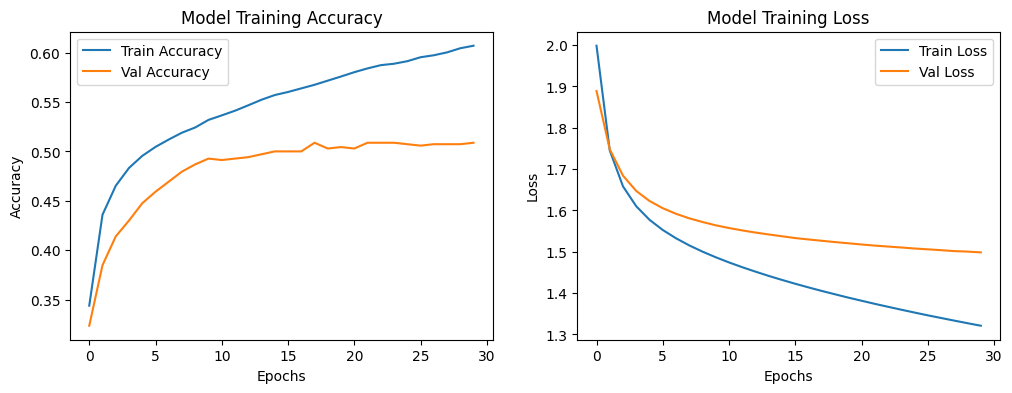

Validation Loss: 1.4985504150390625, Validation F1 Score: 0.4576093852519989, Validation AUC: 0.8809831738471985, 
    Validation Accuracy: 0.508746325969696, Validation Precision: 0.8013937473297119, Validation Recall: 0.3352769613265991
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.85      0.78      0.82        65
           1       0.51      0.45      0.48        94
           2       0.17      0.02      0.04        47
           3       0.68      0.31      0.43        61
           4       0.43      0.58      0.49        69
           5       0.74      0.61      0.67        38
           6       0.61      0.21      0.31        66
           7       0.50      0.11      0.17        19
           8       0.36      0.84      0.50       104
           9       0.68      0.76      0.72        63
          10       0.47      0.37      0.41        60

    accuracy                           0.51       686
   macro avg      

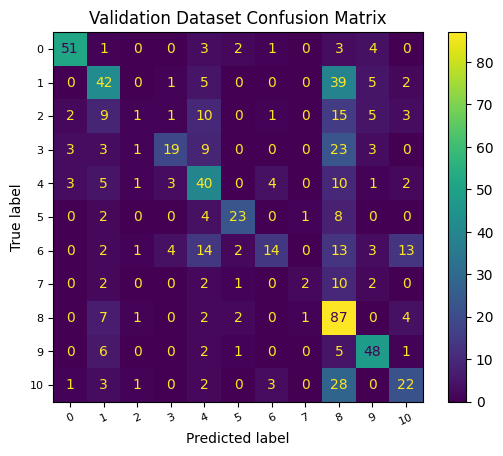

In [10]:
plot_history(model_history)
evaluate_model(model, X_val, Y_val_encoded)

## Logistic Regression with Balanced Oversampled Distribution

In [4]:
import random

### === Setup ===
sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
batch_size = 64
image_size = (224, 224)
seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# === Load the full dataset with batch_size=1 for easier splitting ===
full_dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    seed=seed,
    image_size=image_size,
    batch_size=1,  # one sample per batch, each element is (image, label)
    shuffle=True
)

# Get number of classes (using the attribute from the dataset)
class_names = full_dataset.class_names
num_classes = len(class_names)
print("Found classes:", class_names)

# Determine total samples using cardinality
total_samples = full_dataset.cardinality().numpy()
print("Total samples:", total_samples)

# === Compute split sizes for 80% train, 10% validation, 10% test ===
train_count = int(total_samples * 0.8)
val_count = int(total_samples * 0.1)
test_count = total_samples - train_count - val_count
print("Train samples:", train_count, "Validation samples:", val_count, "Test samples:", test_count)

# === Split using take() and skip() ===
train_dataset = full_dataset.take(train_count)
remaining = full_dataset.skip(train_count)
val_dataset = remaining.take(val_count)
test_dataset = remaining.skip(val_count)

# === Unbatch to get individual samples ===
train_dataset = train_dataset.unbatch()
val_dataset = val_dataset.unbatch()
test_dataset = test_dataset.unbatch()

# === Convert tuples to dictionaries (to avoid dtype packing issues) ===
def tuple_to_dict(image, label):
    if image is None or label is None:
        raise ValueError("None encountered in tuple_to_dict")
    return {"image": image, "label": label}
    
train_dataset = train_dataset.map(tuple_to_dict, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(tuple_to_dict, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(tuple_to_dict, num_parallel_calls=tf.data.AUTOTUNE)

# === Oversample the minority classes in the training dataset ===
# Convert the training dataset to a list for oversampling.
train_list = list(train_dataset)
# After: train_list = list(train_dataset)
for i, example in enumerate(train_list):
    if example["image"] is None or example["label"] is None:
        print(f"Found None in sample {i}")

# Group samples by class.
samples_by_class = [[] for _ in range(num_classes)]
for example in train_list:
    # example is a dict with keys "image" and "label"
    # We use .numpy() to extract the integer label.
    label = int(example["label"].numpy())
    samples_by_class[label].append(example)

# Determine the maximum count among classes.
max_count = max(len(class_samples) for class_samples in samples_by_class)
print("Max samples among classes:", max_count)

# Replicate each class's samples to match the maximum count.
balanced_train_data = []
for class_samples in samples_by_class:
    n = len(class_samples)
    # Compute how many times to repeat the entire class and then take a remainder.
    repeats = max_count // n
    remainder = max_count % n
    balanced_samples = class_samples * repeats + class_samples[:remainder]
    balanced_train_data.extend(balanced_samples)

# Shuffle the balanced training data.
random.shuffle(balanced_train_data)

# Convert the balanced list back to a tf.data.Dataset.
# We create NumPy arrays for images and labels.
balanced_train_images = np.array([ex["image"].numpy() for ex in balanced_train_data])
balanced_train_labels = np.array([ex["label"].numpy() for ex in balanced_train_data])
train_dataset = tf.data.Dataset.from_tensor_slices({
    "image": balanced_train_images,
    "label": balanced_train_labels
})
print("Balanced training samples:", balanced_train_images.shape[0])

for i, ex in enumerate(balanced_train_data):
    if ex["image"] is None or ex["label"] is None:
        print(f"Found None value in sample {i}")

# === Define Data Augmentation for Training ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

def preprocess_train(example):
    # Convert image to float32 [0,1] and apply augmentation.
    image = tf.image.convert_image_dtype(example["image"], tf.float32)
    image = data_augmentation(image)
    return {"image": image, "label": example["label"]}

# Normalization function for validation and test sets.
def normalize(example):
    image = tf.image.convert_image_dtype(example["image"], tf.float32)
    return {"image": image, "label": example["label"]}

# === Build final dataset pipelines ===

def dict_to_tuple(example):
    return (example["image"], example["label"])

# Training: apply augmentation, cache, shuffle, repeat, batch, copy to GPU, and prefetch.
# Convert dictionaries to tuples to avoid issues with operations that expect uniform types.
train_dataset = train_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

# Now rebuild the final training pipeline (without copy_to_device, for instance)
train_dataset = (
    train_dataset
    .map(lambda img, lbl: (tf.image.convert_image_dtype(img, tf.float32), lbl),
         num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1000)
    .repeat()
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .map(lambda img, lbl: (tf.image.convert_image_dtype(img, tf.float32), lbl),
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
    .map(lambda img, lbl: (tf.image.convert_image_dtype(img, tf.float32), lbl),
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

Found 6862 files belonging to 11 classes.
Found classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Total samples: 6862
Train samples: 5489 Validation samples: 686 Test samples: 687


2025-04-17 00:10:20.107887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Max samples among classes: 932
Balanced training samples: 10252


In [5]:
# Training data is already in the right format from oversampling
X_train = balanced_train_images  # Shape: (n_samples, 224, 224, 3)
y_train = balanced_train_labels  # Shape: (n_samples,)

# Convert validation dataset to numpy arrays
val_data = list(val_dataset.unbatch())
X_val = np.stack([x[0].numpy() for x in val_data])  # Shape: (n_samples, 224, 224, 3)
y_val = np.array([x[1].numpy() for x in val_data])  # Shape: (n_samples,)

# Print shapes to verify
print("Training shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)

2025-04-17 00:11:47.130578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training shapes: (10252, 224, 224, 3) (10252,)
Validation shapes: (686, 224, 224, 3) (686,)


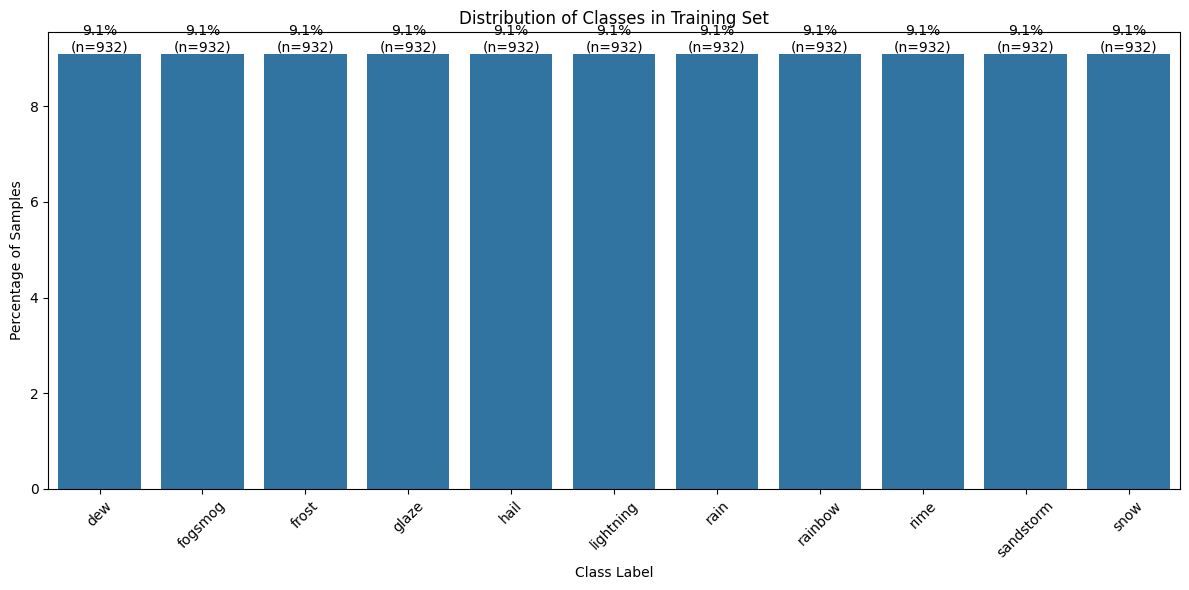

In [6]:
# Plot class distribution
plt.figure(figsize=(12, 6))
class_counts = np.bincount(y_train)
class_percentages = class_counts / len(y_train) * 100

# Create bar plot
sns.barplot(x=np.arange(len(class_counts)), y=class_percentages)

# Add percentage labels on top of bars
for i, (count, percentage) in enumerate(zip(class_counts, class_percentages)):
    plt.text(i, percentage, f'{percentage:.1f}%\n(n={count})', 
             ha='center', va='bottom')

plt.title('Distribution of Classes in Training Set')
plt.xlabel('Class Label')
plt.ylabel('Percentage of Samples')
plt.xticks(np.arange(len(class_counts)), class_names, rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Flatten images and convert to float32
X_train = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255.0
X_val = X_val.reshape(X_val.shape[0], -1).astype('float32') / 255.0

# Convert to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=11)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=11)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(10252, 150528)
(10252, 11)
(686, 150528)
(686, 11)


In [8]:
tf.random.set_seed(1234)

model_oversampled = build_model(X_train.shape[1], learning_rate=0.0001)

model_history_oversampled = model_oversampled.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30)

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 64s 179ms/step - auc: 0.7182 - categorical_accuracy: 0.2632 - f1_score: 0.2540 - loss: 2.1376 - precision: 0.6447 - recall: 0.0102 - val_auc: 0.8337 - val_categorical_accuracy: 0.4373 - val_f1_score: 0.3952 - val_loss: 1.7681 - val_precision: 0.9000 - val_recall: 0.1050
Epoch 2/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - auc: 0.8420 - categorical_accuracy: 0.4344 - f1_score: 0.4198 - loss: 1.7403 - precision: 0.8555 - recall: 0.1076 - val_auc: 0.8483 - val_categorical_accuracy: 0.4650 - val_f1_score: 0.4283 - val_loss: 1.6726 - val_precision: 0.8320 - val_recall: 0.1516
Epoch 3/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - auc: 0.8579 - categorical_accuracy: 0.4615 - f1_score: 0.4495 - loss: 1.6452 - precision: 0.8294 - recall: 0.1623 - val_auc: 0.8545 - val_categorical_accuracy: 0.4854 - val_f1_score: 0.4495 - val_loss: 1.6347 - val_precision: 0.8101 - val_recall: 0.1866
Epoch 4/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - auc: 0.8666

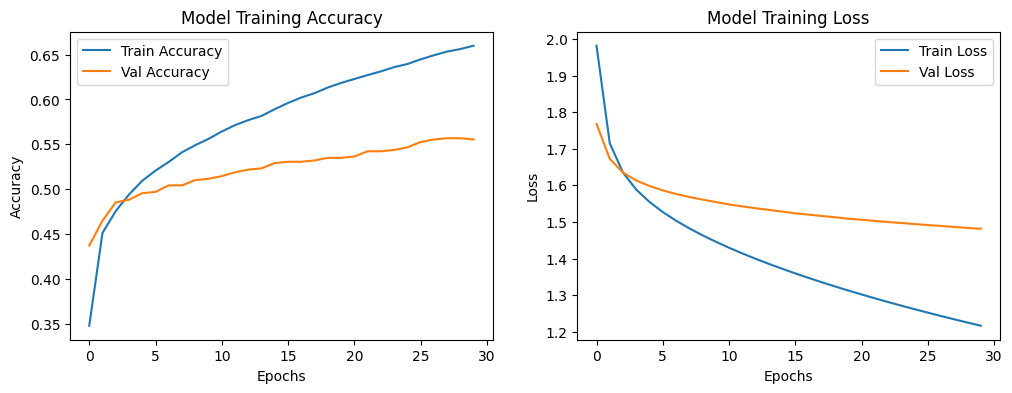

Validation Loss: 1.4816354513168335, Validation F1 Score: 0.5251309871673584, Validation AUC: 0.8841058611869812, 
    Validation Accuracy: 0.5553935766220093, Validation Precision: 0.8129770755767822, Validation Recall: 0.31049561500549316
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.83      0.82      0.83        73
           1       0.58      0.57      0.57        91
           2       0.25      0.14      0.18        42
           3       0.59      0.31      0.41        51
           4       0.42      0.62      0.50        50
           5       0.65      0.75      0.70        40
           6       0.66      0.39      0.49        64
           7       0.30      0.62      0.41        26
           8       0.77      0.40      0.53       117
           9       0.64      0.84      0.73        77
          10       0.33      0.60      0.43        55

    accuracy                           0.56       686
   macro avg    

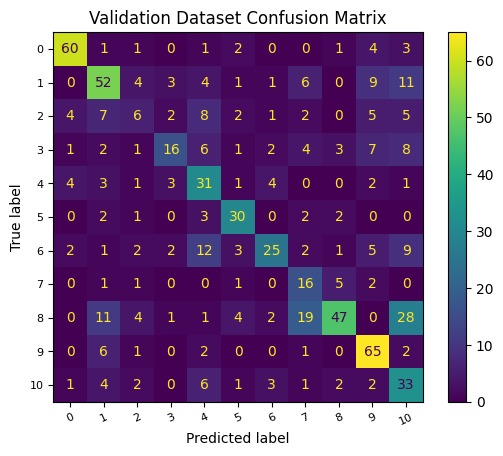

In [9]:
plot_history(model_history_oversampled)
evaluate_model(model_oversampled, X_val, y_val)